# 6. Example Use Case of Therlid Dataset

An example notebook to show how to use the Therlid dataset.  It starts with basic exploratory data analysis (EDA) to visualize the data and then builds a simple predictive model. It’s a practical example for anyone learning to work with the Therlid dataset

## Defines and Imports

In [150]:
# replace with own projectid to pull from bigquery
%env GOOGLE_CLOUD_PROJECT = aiwonglab

env: GOOGLE_CLOUD_PROJECT=aiwonglab


In [151]:
# install necessary packages
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
from google.cloud import bigquery
import matplotlib.pyplot as plt
import missingno as msno
import statsmodels.api as sm
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.cov_struct import Exchangeable
import patsy
import re
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

%load_ext google.colab.data_table

Authenticated
The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [152]:
# load data temperature data stored in google collab or your created version using pd.read_csv()
%%bigquery final_df --project spring-carving-271217

SELECT *
FROM `spring-carving-271217.test.merged_temp_pairs`

Query is running:   0%|          |

Downloading:   0%|          |

## EDA

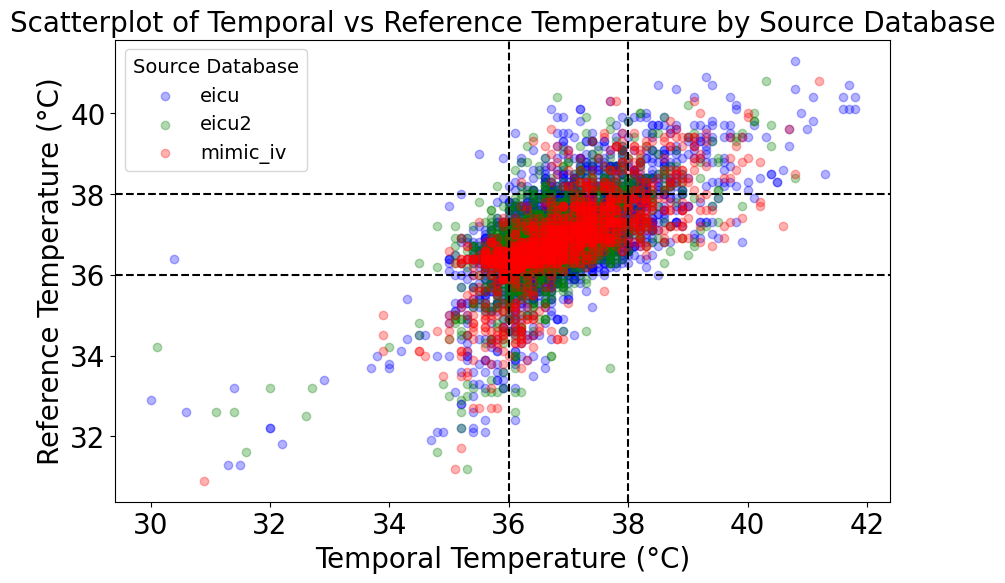

In [153]:
temporal = final_df['temp_c_temporal']
other = final_df['temp_c_reference']
source_db = final_df['source_db']

fig, ax = plt.subplots(figsize=(10, 6))

colors = {'mimic_iv':'red', 'eicu':'blue', 'eicu2':'green'}  # Replace with actual source_db categories
for source in final_df['source_db'].unique():
    subset = final_df[final_df['source_db'] == source]
    ax.scatter(subset['temp_c_temporal'],
               subset['temp_c_reference'],
               alpha=0.3, label=source, color=colors.get(source, 'gray'))

ax.axvline(x=36, color='black', linestyle='--')
ax.axvline(x=38, color='black', linestyle='--')
ax.axhline(y=36, color='black', linestyle='--')
ax.axhline(y=38, color='black', linestyle='--')
ax.set_title("Scatterplot of Temporal vs Reference Temperature by Source Database", fontsize=20)
ax.set_xlabel("Temporal Temperature (°C)", fontsize=20)
ax.set_ylabel("Reference Temperature (°C)", fontsize=20)


ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.legend(title='Source Database', title_fontsize=14, fontsize=14)

plt.show()

## Linear Model with Generalized Estimating Equations

In [154]:
# using only the first pair for each subject
first_pair = final_df[final_df['pair_seq'].str.endswith('-1')]

# selected vars for model
vars = ['unique_hospital_admission_id', 'race_ethnicity', 'admission_age', 'sex_female', 'source_db', 'comorbidity_score_value', 'hidden_SIRS', 'sofa_day1']

selected_df = first_pair[vars]

selected_df

unique_hospital_admission_id race_ethnicity  admission_age  sex_female  \
2                              2122          White             81           0   
3                              1977          White             69           1   
4                              1922          White             74           1   
5                              2144          White             51           1   
6                              2110          White             79           0   
...                             ...            ...            ...         ...   
13276                          7657          White             67           0   
13277                          7669          White             55           0   
13278                          7304          White             83           1   
13279                          2022          White             50           0   
13280                          7693          Asian             47           0   

      source_db  comorbidity_score_value  hidden_SIRS  sofa_day1  
2          eicu                        4        False        5.0  
3          eicu                        8        False        NaN  
4          eicu                        7        False        2.0  
5          eicu                        1        False        2.0  
6          eicu                        6        False        NaN  
...         ...                      ...          ...        ...  
13276     eicu2                        3        False        5.0  
13277     eicu2                        1         True        9.0  
13278     eicu2                        4        False        4.0  
13279      eicu                        1        False        0.0  
13280     eicu2                        1        False        6.0  

[8765 rows x 8 columns]

In [155]:
# drop pairs that don't have sofa info
completed_pairs = selected_df[selected_df['sofa_day1'].notna()]
# convert hidden SIRS to float
completed_pairs['hidden_SIRS'] = completed_pairs['hidden_SIRS'].astype('float64')
completed_pairs

unique_hospital_admission_id race_ethnicity  admission_age  sex_female  \
2                              2122          White             81           0   
4                              1922          White             74           1   
5                              2144          White             51           1   
7                              2142          White             72           1   
8                              1972          White             74           1   
...                             ...            ...            ...         ...   
13276                          7657          White             67           0   
13277                          7669          White             55           0   
13278                          7304          White             83           1   
13279                          2022          White             50           0   
13280                          7693          Asian             47           0   

      source_db  comorbidity_score_value  hidden_SIRS  sofa_day1  
2          eicu                        4          0.0        5.0  
4          eicu                        7          0.0        2.0  
5          eicu                        1          0.0        2.0  
7          eicu                        6          0.0        1.0  
8          eicu                        4          0.0        6.0  
...         ...                      ...          ...        ...  
13276     eicu2                        3          0.0        5.0  
13277     eicu2                        1          1.0        9.0  
13278     eicu2                        4          0.0        4.0  
13279      eicu                        1          0.0        0.0  
13280     eicu2                        1          0.0        6.0  

[6790 rows x 8 columns]

In [163]:
# convert types to float64 to pass into statsmodel
completed_pairs = completed_pairs.astype({
    'admission_age': 'float64',
    'sex_female': 'float64',
    'comorbidity_score_value': 'float64'
})

In [172]:
completed_pairs['race_ethnicity'] = completed_pairs['race_ethnicity'].astype('category')
# reorder to put 'white' as the reference category
completed_pairs['race_ethnicity'] = completed_pairs['race_ethnicity'].cat.reorder_categories(
    ['White', 'American Indian / Alaska Native', 'Asian', 'Black', 'Hispanic OR Latino', 'Native Hawaiian / Pacific Islander', 'Unknown'],
    ordered=False
)
# create matrices to plug inot the statsmodel
y, X = patsy.dmatrices('hidden_SIRS ~ race_ethnicity + C(sex_female) + source_db + admission_age + comorbidity_score_value + sofa_day1', data=completed_pairs, return_type='dataframe')


In [174]:
groups = completed_pairs['unique_hospital_admission_id']

# define the GEE model with independence strucutre and grouping by hosptial admission id
model_gee_sirs = sm.GEE(y, X, groups=groups, cov_struct=sm.cov_struct.Independence(), family=sm.families.Binomial())
# fit the model
results = model_gee_sirs.fit()
# print the summary
print(results.summary())

                               GEE Regression Results                              
Dep. Variable:                 hidden_SIRS   No. Observations:                 6790
Model:                                 GEE   No. clusters:                     6732
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   3
Family:                           Binomial   Mean cluster size:                 1.0
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Sun, 01 Sep 2024   Scale:                           1.000
Covariance type:                    robust   Time:                         22:29:43
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
In